<h1>Import frameworks</h1>

In [6]:
from matplotlib import pyplot
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


<h1>Correlation</h1>

In [7]:
def calculate_correlation(data, variable, method):
    # Compute Pearson correlation coefficients
    correlation_matrix = data.corr(method = method)

    # Extract correlation coefficients of the target variable (life expectancy)
    correlation_with_life_expectancy = correlation_matrix[variable]
    # Remove the target variable from the correlation coefficients
    correlation_without_life_expectancy = correlation_with_life_expectancy.drop(variable)

    # Find the variable with the highest absolute correlation coefficient
    strongest_correlation_variable = correlation_without_life_expectancy.abs().idxmax()
    strongest_correlation_coefficient = correlation_without_life_expectancy.abs().max()

    print(f"The variable '{strongest_correlation_variable}' has the strongest " + method + f" correlation with a coefficient of {strongest_correlation_coefficient:.2f}.")

    fig, ax = pyplot.subplots(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
    ax.set_title(method + ' Correlation Coefficients')
    fig.savefig(method + "_correlation.pdf")
    
    return strongest_correlation_variable, correlation_matrix


<h1>Train model</h1>

In [8]:
def train_linear_regression_model(X_train, X_test, y_train, y_test, variables, prefix = ''):
    # Train a linear regression model using the variable with the strongest correlation
    model = LinearRegression().fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    _, rows = X_test.shape
    if rows == 1:
        fig, ax = pyplot.subplots(figsize=(8, 6), layout='constrained')
        ax.scatter(X_test, y_test, color='blue')
        ax.scatter(X_test, y_pred, color='red')
        ax.set_xlabel(prefix + " " + variables)
        ax.set_ylabel('Life Expectancy (years)')
        ax.text(0.1, 0.7, f'R^2 = {r2:.2f}', ha='center', va='center', transform=ax.transAxes)
        filename = prefix + "_linear_regression_" + variables + ".pdf"
        filename = filename.replace(' ', '_').lower()
        fig.savefig(filename, bbox_inches='tight')
   

    mse = mean_squared_error(y_test, y_pred)
    print("Trained model with the following variables " + prefix + ": ", variables)
    print(f"The mean squared error for is {mse:.2f}.")



<h1>Find linear variable</h1>

In [9]:
def transform_variable(X_train, y_train, correlation_variable):
    pd.options.mode.chained_assignment = None

    X_train_selected = X_train[[correlation_variable]]

    X_train_selected['log'] = np.log(X_train[[correlation_variable]])
    X_train_selected['sqrt'] = np.sqrt(X_train[[correlation_variable]])
    X_train_selected['reciprocal'] = 1/(X_train[[correlation_variable]])

    fig, ax = pyplot.subplots(figsize=(8, 6), layout='constrained')
    ax.scatter(X_train_selected.iloc[:, 0], y_train, color='blue', label='Original')
    ax.scatter(X_train_selected['log'], y_train, color='red', label='Log')
    ax.scatter(X_train_selected['sqrt'], y_train, color='green', label='Square root')
    ax.scatter(X_train_selected['reciprocal'], y_train, color='black', label='Reciprocal')
    ax.set_ylabel('Life Expectancy (years)')
    ax.set_xlabel(correlation_variable)

    ax.legend()
    fig.savefig("linear_transformation.pdf", bbox_inches='tight')
   

<h1>Read csv, examine correlation and train models</h1>

The variable 'Human Development Index (value)' has the strongest pearson correlation with a coefficient of 0.93.
Trained model with the following variables :  Human Development Index (value)
The mean squared error for is 9.97.
The variable 'Median Age, as of 1 July (years)' has the strongest spearman correlation with a coefficient of 0.92.
Trained model with the following variables :  Median Age, as of 1 July (years)
The mean squared error for is 13.80.
Trained model with the following variables [Log]:  Median Age, as of 1 July (years)
The mean squared error for is 12.18.
Trained model with the following variables [Sqrt]:  Median Age, as of 1 July (years)
The mean squared error for is 12.72.
Trained model with the following variables [Reciprocal]:  Median Age, as of 1 July (years)
The mean squared error for is 12.80.
Trained model with the following variables :  ['Expected Years of Schooling, female (years)', 'Coefficient of human inequality', 'Gross National Income Per Capita (2017 PP

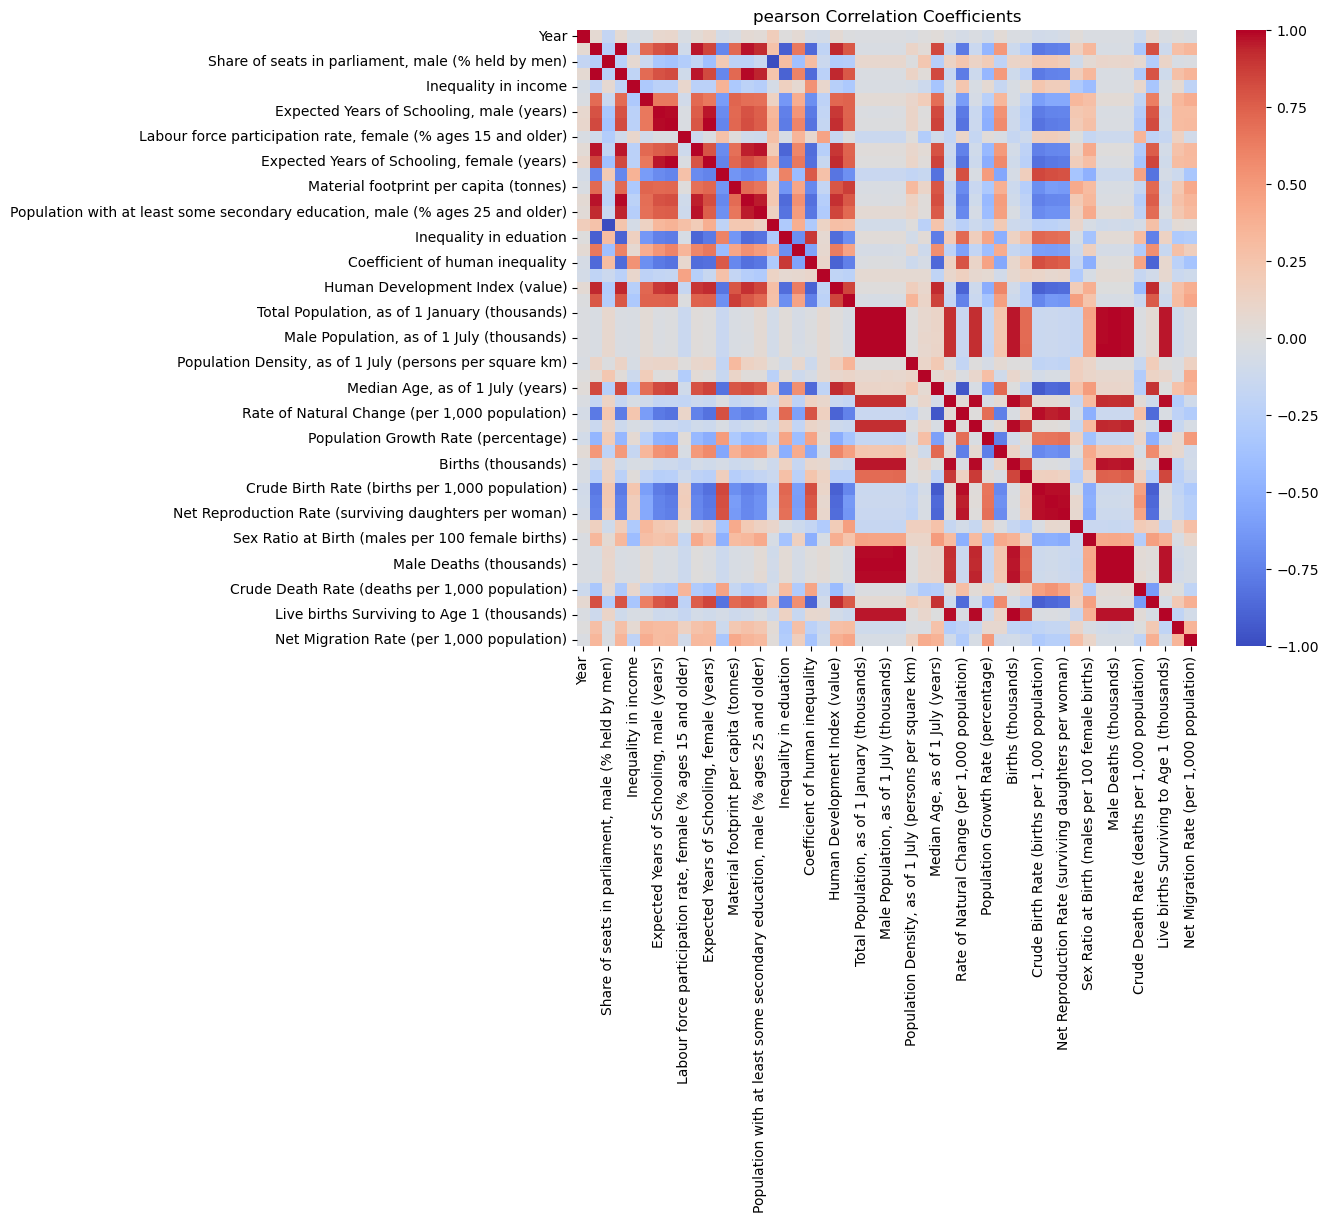

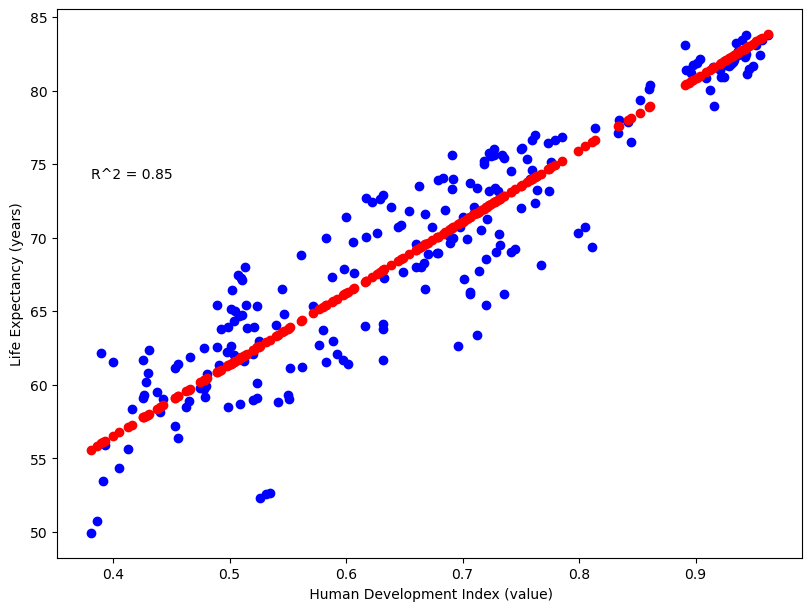

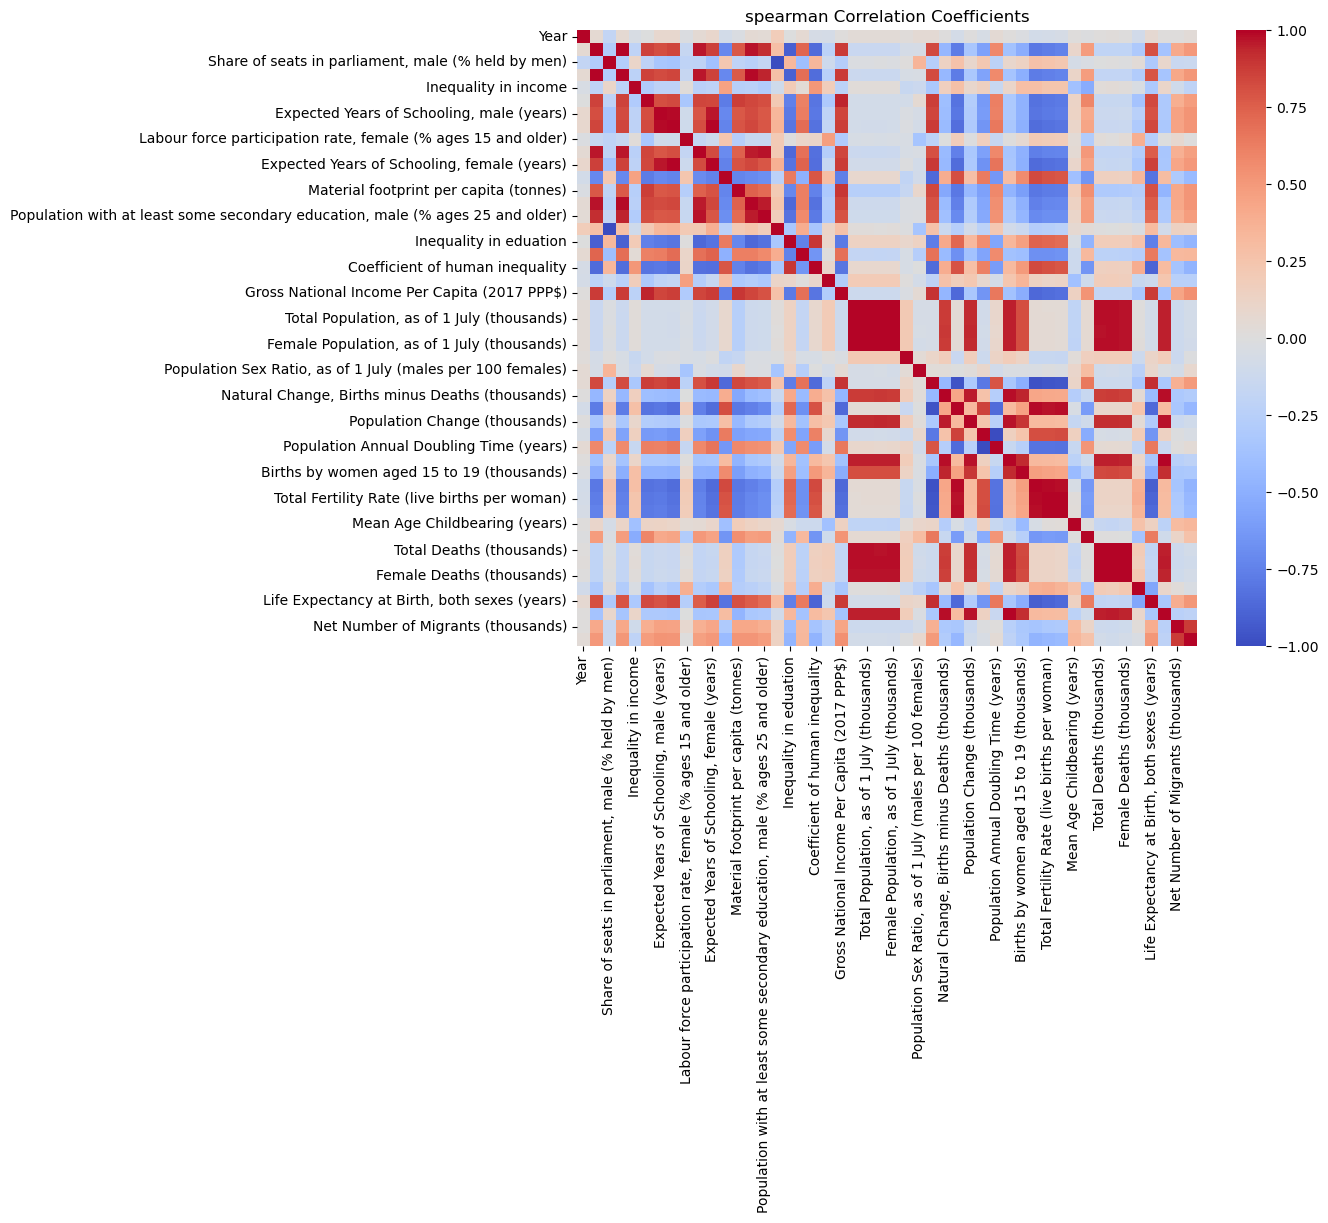

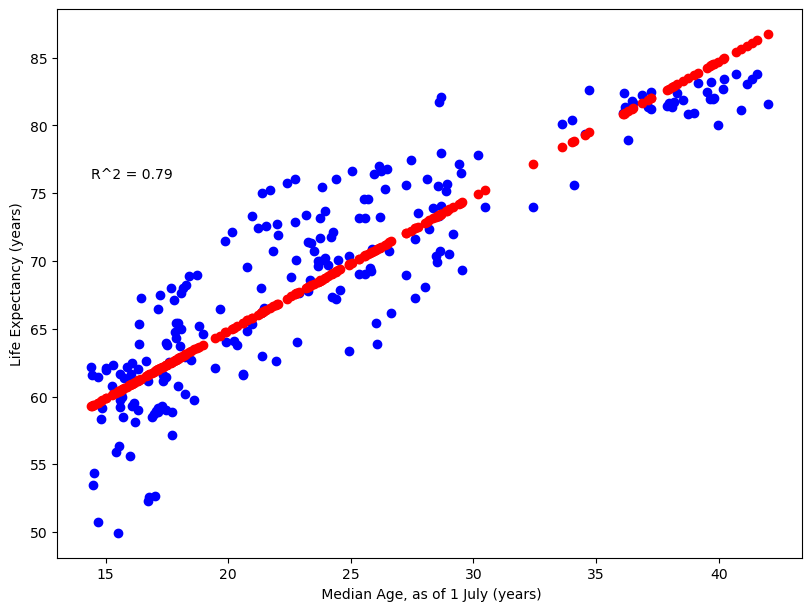

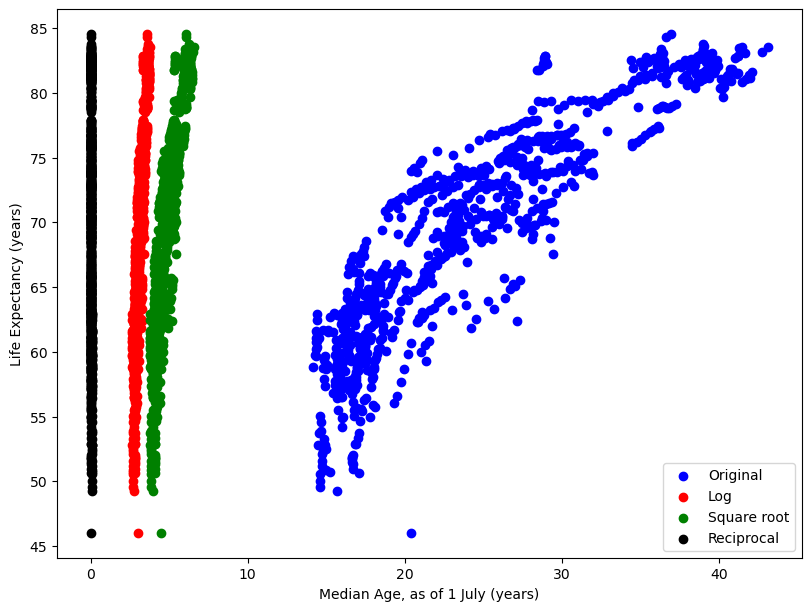

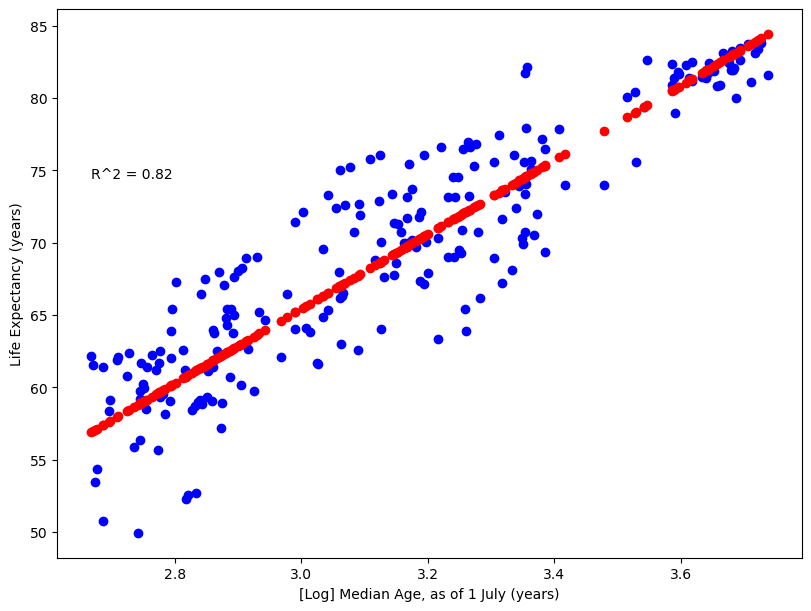

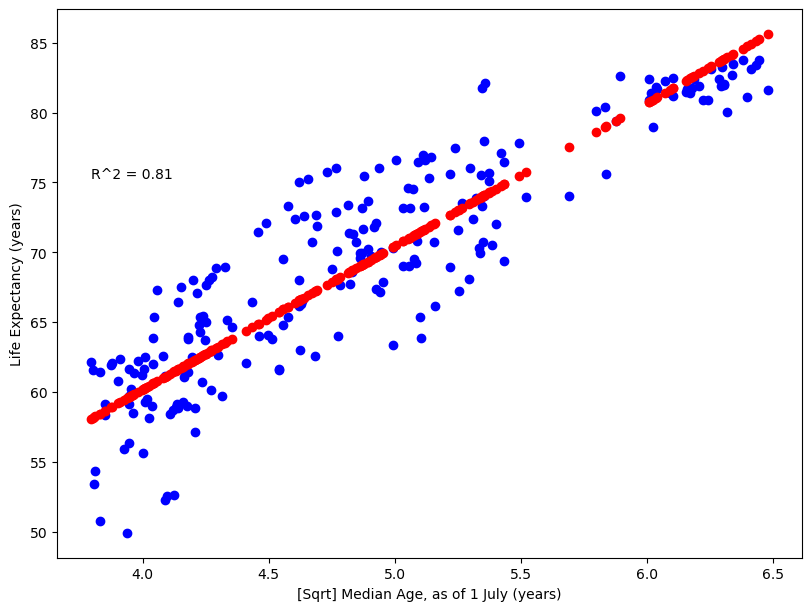

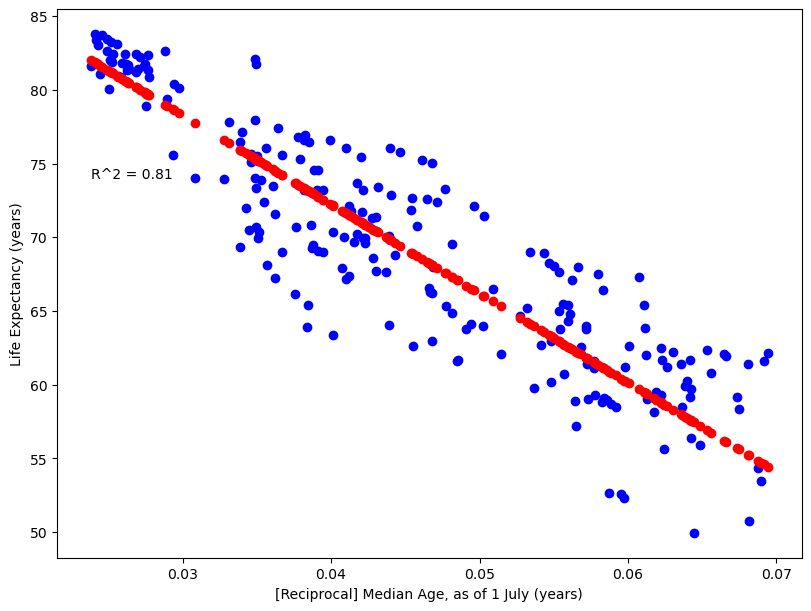

In [11]:
file_path = "../life_expectancy.csv"  
life_expectancy = pd.read_csv(file_path,  sep=',',).dropna()
LEB = 'Life Expectancy at Birth, both sexes (years)'
life_expectancy.set_index('Country', inplace=True)

life_expectancy_train, life_expectancy_test = train_test_split(life_expectancy, test_size=0.2)

X_train = life_expectancy_train.drop(LEB, axis=1) 
X_test =  life_expectancy_test.drop(LEB, axis=1) 
y_train = life_expectancy_train[LEB] 
y_test = life_expectancy_test[LEB]



strongest_pearson_correlation_variable, correlation_pearson = calculate_correlation(life_expectancy_train, LEB, 'pearson')
train_linear_regression_model(X_train[[strongest_pearson_correlation_variable]], X_test[[strongest_pearson_correlation_variable]], y_train, y_test, strongest_pearson_correlation_variable)

strongest_spearman_correlation_variable, correlation_spearman = calculate_correlation(life_expectancy_train.drop(strongest_pearson_correlation_variable, axis=1), LEB, 'spearman')
train_linear_regression_model(X_train[[strongest_spearman_correlation_variable]], X_test[[strongest_spearman_correlation_variable]], y_train, y_test, strongest_spearman_correlation_variable)
transform_variable(X_train, y_train, strongest_spearman_correlation_variable)
train_linear_regression_model(np.log(X_train[[strongest_spearman_correlation_variable]]), np.log(X_test[[strongest_spearman_correlation_variable]]), y_train, y_test, strongest_spearman_correlation_variable, "[Log]")
train_linear_regression_model(np.sqrt(X_train[[strongest_spearman_correlation_variable]]), np.sqrt(X_test[[strongest_spearman_correlation_variable]]), y_train, y_test, strongest_spearman_correlation_variable, "[Sqrt]")
train_linear_regression_model(1/(X_train[[strongest_spearman_correlation_variable]]), 1/(X_test[[strongest_spearman_correlation_variable]]), y_train, y_test, strongest_spearman_correlation_variable, "[Reciprocal]")

threshold = 0.85  
correlation_spearman_no_LEB = correlation_spearman.drop([LEB])

relevant_variables = correlation_spearman_no_LEB[abs(correlation_spearman_no_LEB['Life Expectancy at Birth, both sexes (years)']) > threshold].index.tolist()
train_linear_regression_model(X_train[relevant_variables], X_test[relevant_variables], y_train, y_test, relevant_variables)


